In [87]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import pdist, squareform
import dask.array as da
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed


#Extra settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [88]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print('File not loaded')

Train df shape:  (86584, 14)
Test df shape:  (6576, 13)


In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [90]:
#Creating  a bechmark model using num cols and evaluating it.
train_df_benchmark_num=train_df.select_dtypes(include='number')

X=train_df_benchmark_num.drop(['GT_NO2'],axis=1)
y=train_df_benchmark_num['GT_NO2']

X=X.fillna(0)
y=y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# model=LinearRegression()
# model.fit(X,y)
# y_pred=model.predict(X)

# # print("R2 Score: ",r2_score(y,y_pred))

(69267, 10) (17317, 10) (69267,) (17317,)


In [91]:
train_df_benchmark_num.columns

Index(['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2'],
      dtype='object')

In [92]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 182.40370236092463
Root Mean Squared Error: 13.505691480295432
R-squared: 0.4026951110506707


In [93]:
#Creation of model 2. 
#Do non functional checks
#)Doing EDA to understand what features needs to be engineered


In [94]:
#Null check function
def null_zero_check(df):
    null_values = df.isnull().sum()
    zero_values = df.apply(lambda col: (col == 0).sum())
    Total_record_count=df.shape[0]
    dataype = df.dtypes
    summary_df = pd.DataFrame({'Null count': null_values,
                               'Null_count_percent': null_values/Total_record_count*100,
                                'Zero count': zero_values,
                                'Zero_count_percent': zero_values/Total_record_count*100,
                                'Datatype': dataype})
    return summary_df

#Crosscheck Feature dTypes
def check_feature_dtypes(train_df, test_df):
    common_cols=train_df.columns.intersection(test_df.columns)
    mismatched_dtypes = []
    for col in common_cols:
        if train_df[col].dtype != test_df[col].dtype:
            mismatched_dtypes.append(
                (col, {"train": train_df[col].dtype, "test": test_df[col].dtype})
            )

    # Return True if no mismatches, False otherwise
    if not mismatched_dtypes:
        return True, mismatched_dtypes
    else:
        return False, mismatched_dtypes
    
#Function to Combine train and test data.Remove target from the train data before combining

def combine_df(df1,df2,tgt_col):
    trin_df_drop=df1.drop([tgt_col],axis=1)
    combined_df=pd.concat([trin_df_drop,df2],axis=0)
    return combined_df

#Function to check for duplicates 
def check_duplicates(df, columns=None):
    if columns is None:
        columns = df.columns

    duplicates = df[df.duplicated(subset=columns, keep=False)]
    return duplicates

#Final report generation
def perform_data_analysis(train_df, test_df,columns=None):
    print('Null check in train_df:')
    display(null_zero_check(train_df))
    print('Null check in test_df:')
    display(null_zero_check(test_df))
    print('Null check in combined_df:')
    combined_df=combine_df(train_df,test_df,'GT_NO2')
    print('Combined_df shape: ',combined_df.shape)
    print('Is rows in train_df + test_df = combined_df?',train_df.shape[0]+test_df.shape[0]==combined_df.shape[0])
    display(null_zero_check(combined_df))

    print("Check describe for train_df")
    display(train_df.describe(include='all').T)
    print("Check describe for test_df")
    display(test_df.describe(include='all').T)
    print("Check describe for combined_df")
    display(combined_df.describe(include='all').T)

    print('Check for dataype mismatch between Train and Test.If True then no mismatch:',check_feature_dtypes(train_df, test_df))

    print('Check for duplicates in train_df')
    display(check_duplicates(train_df,columns))

    print('Check for duplicates in test_df')
    display(check_duplicates(test_df,columns))  

    print('Check for duplicates in combined_df')
    display(check_duplicates(combined_df,columns))

def model_training(train_df, test_df, train_survived):
    model = LinearRegression()
    model.fit(train_df, train_survived)
    prediction = model.predict(test_df)
    return prediction

In [95]:
train_df_model_2=train_df.copy()
test_df_model_2=test_df.copy()

In [96]:
perform_data_analysis(train_df_model_2,test_df_model_2)
print('''
We can see 79% of the precipitation as 0. Though  Lombardy and Veneto regions generally has  Mediterranean climate
it is possible that precipitation can be zero in summer months. We have date column and this can be used to crosscheck.
Summer months generally starts from June 1st and ends on August 31st. We can do time series analysis for this

We can see 9% zeros for CloudFraction. Need to check which other feature is collinear with it.

--------------

41% of NO2_trop is null. We can solve 25% of it as NO2_strat+NO2_trop=NO2_total


'''
)

Null check in train_df:


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,object
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,68723,79.371477,float64
LST,39786,45.950753,0,0.000000,float64
AAI,12875,14.869953,0,0.000000,float64
CloudFraction,12875,14.869953,7756,8.957775,float64
NO2_strat,12875,14.869953,0,0.000000,float64


Null check in test_df:


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,object
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,5228,79.501217,float64
LST,2981,45.331509,0,0.000000,float64
AAI,868,13.199513,0,0.000000,float64
CloudFraction,868,13.199513,874,13.290754,float64
NO2_strat,868,13.199513,0,0.000000,float64


Null check in combined_df:
Combined_df shape:  (93160, 13)
Is rows in train_df + test_df = combined_df? True


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,object
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,73951,79.380635,float64
LST,42767,45.907042,0,0.000000,float64
AAI,13743,14.752040,0,0.000000,float64
CloudFraction,13743,14.752040,8630,9.263632,float64
NO2_strat,13743,14.752040,0,0.000000,float64


Check describe for train_df


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_Zindi,86584,86582,ID_ZHFIGQ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,86584,1096,1/1/19,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,86584,79,PD01,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,86584.0,NaN,NaN,NaN,45.421456,0.225409,44.924694,45.249544,45.478996,45.601232,45.889734
LON,86584.0,NaN,NaN,NaN,10.014272,1.056637,8.736497,9.195325,9.611738,10.683357,12.590682
Precipitation,86584.0,NaN,NaN,NaN,2.585528,7.617394,0.0,0.0,0.0,0.0,135.396805
LST,46798.0,NaN,NaN,NaN,299.268841,10.927167,253.2,290.92,300.76,307.94,327.84
AAI,73709.0,NaN,NaN,NaN,-1.274999,0.693003,-5.196266,-1.749425,-1.349746,-0.878857,2.14302
CloudFraction,73709.0,NaN,NaN,NaN,0.200606,0.259607,0.0,0.0239,0.078478,0.278451,1.0
NO2_strat,73709.0,NaN,NaN,NaN,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000073


Check describe for test_df


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_Zindi,6576,6576,ID_2MYNQS,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,6576,1096,1/1/19,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,6576,6,PD03,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,6576.0,NaN,NaN,NaN,45.363205,0.260667,45.131947,45.151743,45.237853,45.582894,45.836941
LON,6576.0,NaN,NaN,NaN,10.489789,1.306469,8.842165,9.146666,10.398575,11.642394,12.510362
Precipitation,6576.0,NaN,NaN,NaN,2.544018,7.475326,0.0,0.0,0.0,0.0,103.227943
LST,3595.0,NaN,NaN,NaN,299.394019,11.034047,254.72,291.04,300.9,308.12,324.14
AAI,5708.0,NaN,NaN,NaN,-1.27339,0.691949,-3.716866,-1.753032,-1.363993,-0.876478,2.474583
CloudFraction,5708.0,NaN,NaN,NaN,0.203512,0.269866,0.0,0.01336,0.070884,0.296377,1.0
NO2_strat,5708.0,NaN,NaN,NaN,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000072


Check describe for combined_df


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_Zindi,93160,93158,ID_ZHFIGQ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,93160,1760,1/1/19,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,93160,85,PD01,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,93160.0,NaN,NaN,NaN,45.417344,0.228563,44.924694,45.233494,45.463753,45.582894,45.889734
LON,93160.0,NaN,NaN,NaN,10.047838,1.083039,8.736497,9.195325,9.643651,10.781408,12.590682
Precipitation,93160.0,NaN,NaN,NaN,2.582597,7.607421,0.0,0.0,0.0,0.0,135.396805
LST,50393.0,NaN,NaN,NaN,299.277771,10.934763,253.2,290.94,300.78,307.94,327.84
AAI,79417.0,NaN,NaN,NaN,-1.274884,0.692923,-5.196266,-1.749649,-1.350884,-0.878793,2.474583
CloudFraction,79417.0,NaN,NaN,NaN,0.200815,0.260357,0.0,0.023168,0.077997,0.279655,1.0
NO2_strat,79417.0,NaN,NaN,NaN,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000073


Check for dataype mismatch between Train and Test.If True then no mismatch: (True, [])
Check for duplicates in train_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2


Check for duplicates in test_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure


Check for duplicates in combined_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure



We can see 79% of the precipitation as 0. Though  Lombardy and Veneto regions generally has  Mediterranean climate
it is possible that precipitation can be zero in summer months. We have date column and this can be used to crosscheck.
Summer months generally starts from June 1st and ends on August 31st. We can do time series analysis for this

We can see 9% zeros for CloudFraction. Need to check which other feature is collinear with it.

--------------

41% of NO2_trop is null. We can solve 25% of it as NO2_strat+NO2_trop=NO2_total





In [97]:
train_df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [98]:
numeric_features = train_df_model_2.select_dtypes(include=['int64', 'float64']).columns


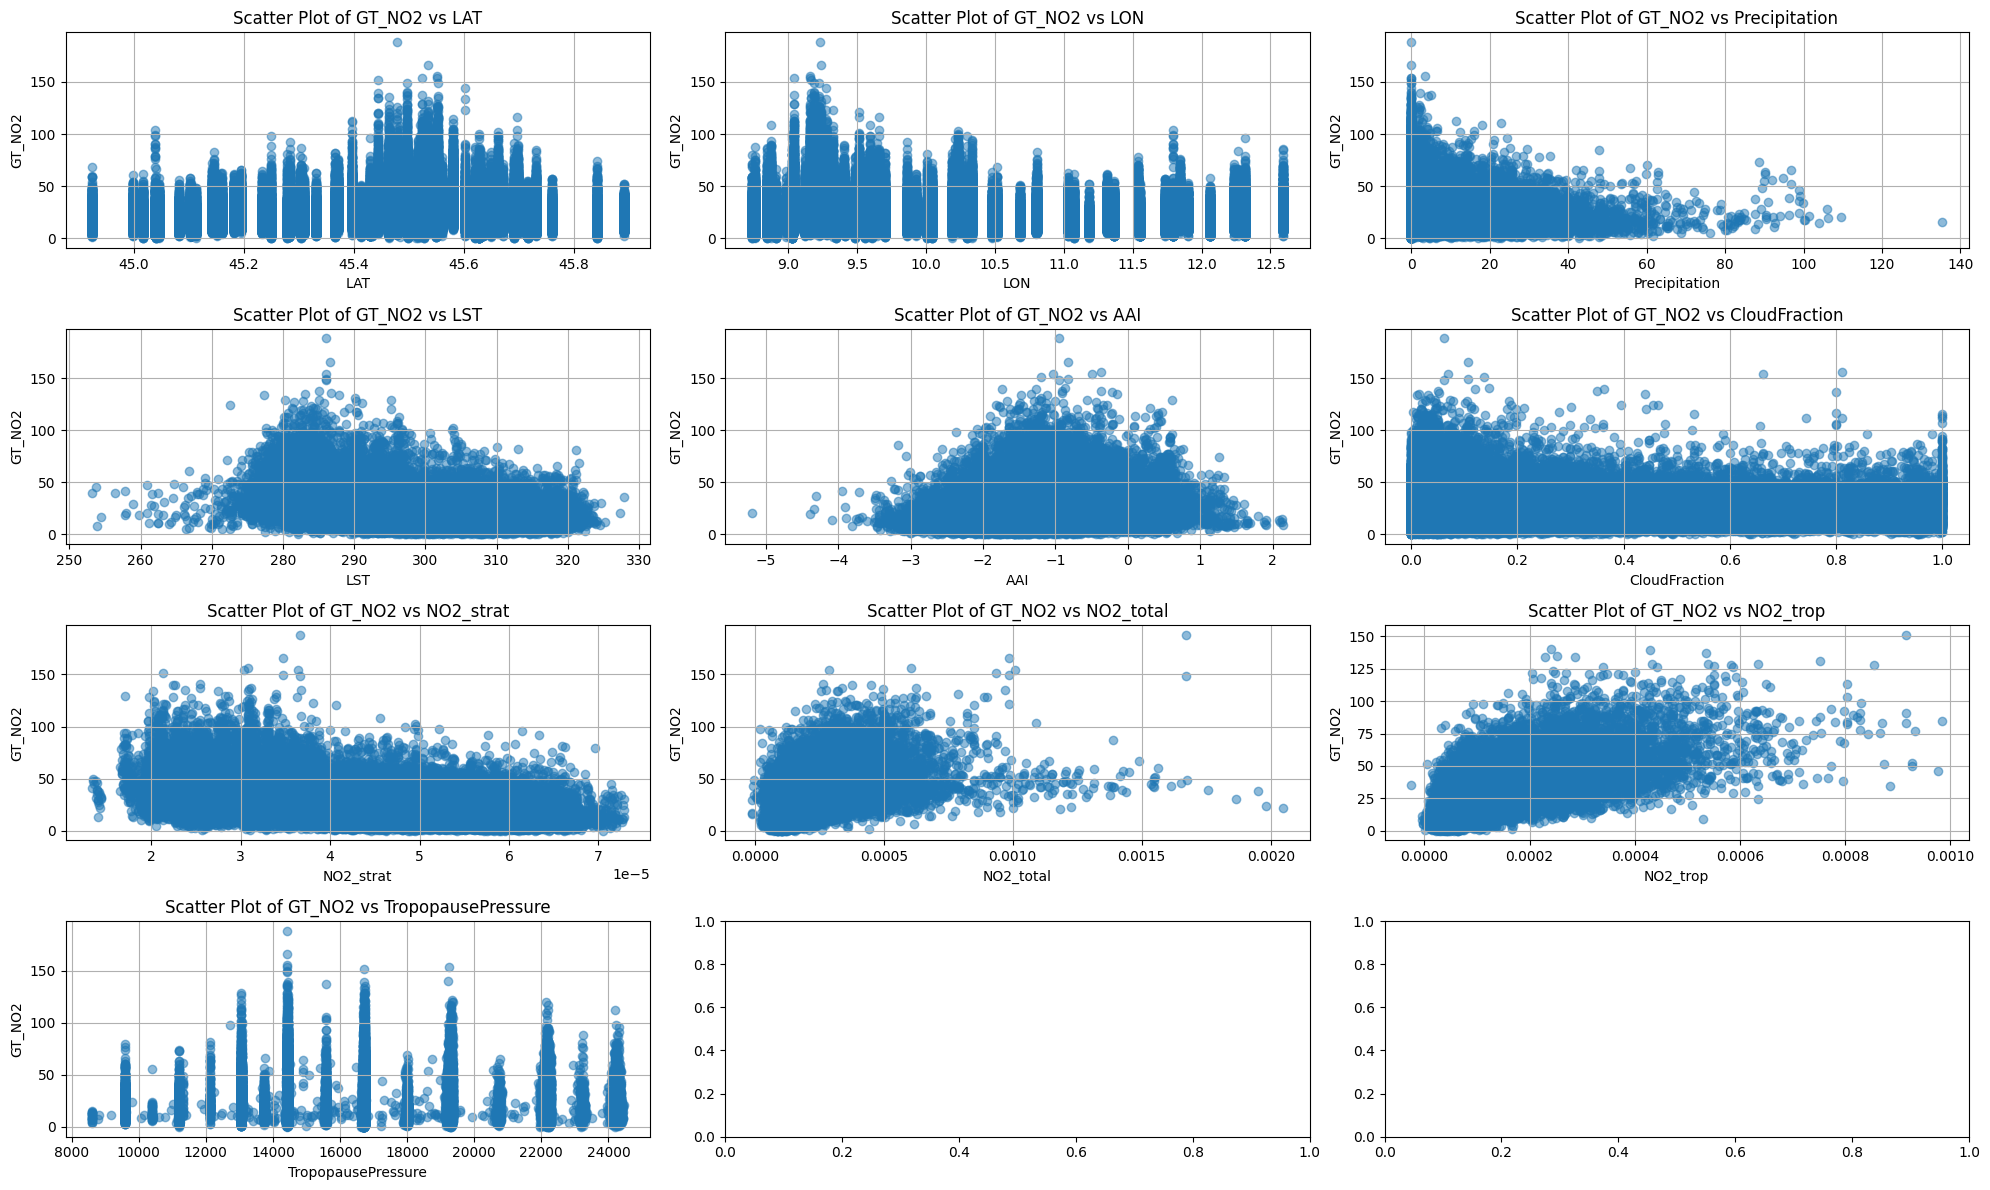



GT_NO2 vs LAT:- Highest concentrations appear around 45.4-45.6 degrees latitude.Suggests geographical hotspots of NO2 pollution.

GT_NO2 vs LON:- Highest concentrations appear around 9.0-9.4 degrees longitude. suggests geographical hotspots of NO2 pollution.

We will create heat maps or contour plots using LAT and LON data to visualize NO2 hotspots.
Crosscheck using  spatial clustering algorithms to identify areas of high NO2 concentration.
      
GT_NO2 vs Precipitation:- Variability is high .We can see GT_NO2 decreasing with increasing precipitation.

GT_NO2 vs LST:- There's a clear diurnal pattern in GT_NO2 concentrations against LST as 
      LST directly represents time of day.Will investigate this with dates.

GT_NO2 vs AAI: This is also showing same pattern as GT_NO2 vs LST: They may be correlated with each other.

GT_NO2 vs NO2_strat:-GT_NO2 is decreasing with increasigng NO2_strat. The variability also decreases.

GT_NO2 vs NO2_total:- We can see a possitive correlation betw

In [99]:
num_rows = 4
num_cols = 3

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the numeric features and create scatter plots
for i, feature in enumerate(numeric_features):
    if feature != 'GT_NO2':  # Exclude the dependent variable itself
        ax = axes[i]
        ax.scatter(train_df_model_2[feature], train_df_model_2['GT_NO2'], alpha=0.5)
        ax.set_title(f'Scatter Plot of GT_NO2 vs {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('GT_NO2')
        ax.grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

print('''

GT_NO2 vs LAT:- Highest concentrations appear around 45.4-45.6 degrees latitude.Suggests geographical hotspots of NO2 pollution.

GT_NO2 vs LON:- Highest concentrations appear around 9.0-9.4 degrees longitude. suggests geographical hotspots of NO2 pollution.

We will create heat maps or contour plots using LAT and LON data to visualize NO2 hotspots.
Crosscheck using  spatial clustering algorithms to identify areas of high NO2 concentration.
      
GT_NO2 vs Precipitation:- Variability is high .We can see GT_NO2 decreasing with increasing precipitation.

GT_NO2 vs LST:- There's a clear diurnal pattern in GT_NO2 concentrations against LST as 
      LST directly represents time of day.Will investigate this with dates.

GT_NO2 vs AAI: This is also showing same pattern as GT_NO2 vs LST: They may be correlated with each other.

GT_NO2 vs NO2_strat:-GT_NO2 is decreasing with increasigng NO2_strat. The variability also decreases.

GT_NO2 vs NO2_total:- We can see a possitive correlation between GT_NO2 and NO2_total.The density of points decreases as both variables increase.

GT_NO2 vs NO2_Trop:- We can see a possitive correlation between GT_NO2 and NO2_Trop

GT_NO2 vs CloudFraction:- As cloud fraction increases, the maximum NO2 concentrations tend to decrease.
      The variability in NO2 seems to decrease as cloud fraction increases.

GT_NO2 vs TropopausePressure:- The relationship isn't linear.We will see if we can convert it into catgorical
    as I can see groups in the plot.
      ''')

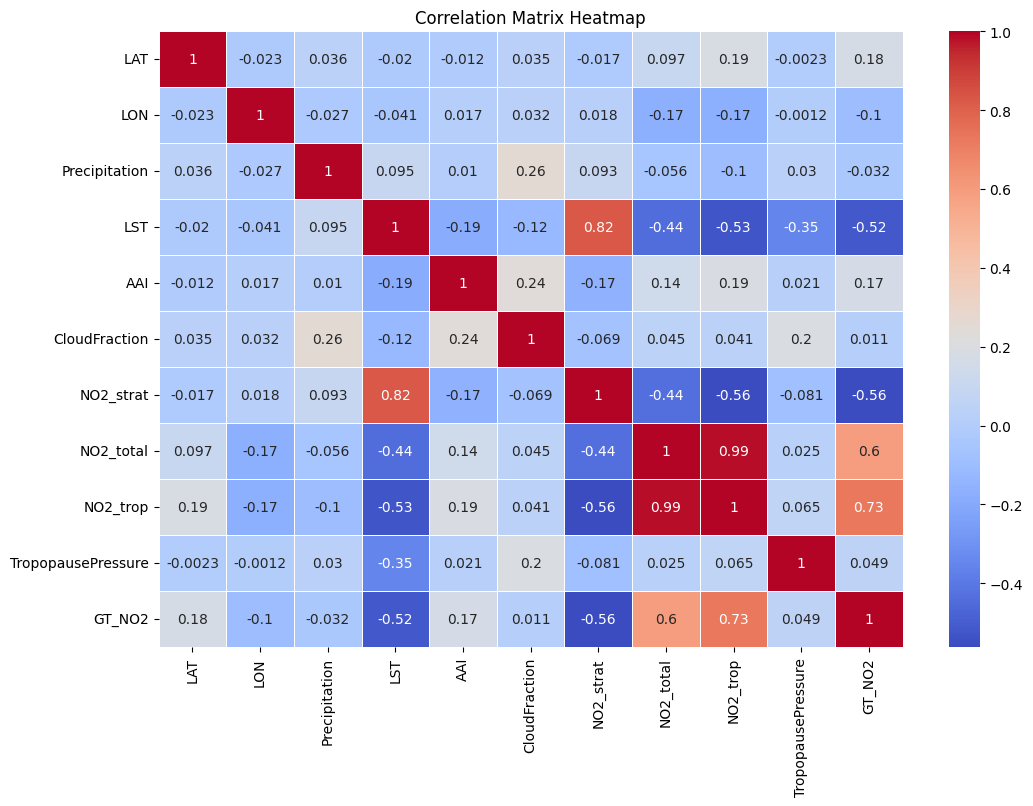

In [100]:
train_df_model_2_corr_check_df=train_df_model_2[numeric_features].copy()
train_df_model_2_corr_matrix_df=train_df_model_2_corr_check_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_model_2_corr_matrix_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [101]:
train_df_model_2_corr_matrix_df_sort =train_df_model_2_corr_matrix_df.unstack().reset_index()
train_df_model_2_corr_matrix_df_sort.columns= ['Variable1', 'Variable2', 'Correlation']
train_df_model_2_corr_matrix_df_sort = train_df_model_2_corr_matrix_df_sort[train_df_model_2_corr_matrix_df_sort['Variable1'] != train_df_model_2_corr_matrix_df_sort['Variable2']]
# train_df_model_2_corr_matrix_df_sort = train_df_model_2_corr_matrix_df_sort.loc[train_df_model_2_corr_matrix_df_sort.apply(lambda x: x['Variable1'] < x['Variable2'], axis=1)]
train_df_model_2_corr_matrix_df_sort=train_df_model_2_corr_matrix_df_sort.sort_values(by='Correlation',ascending=False)
print(train_df_model_2_corr_matrix_df_sort[train_df_model_2_corr_matrix_df_sort['Correlation']>=0.3])
print('\n')
print(train_df_model_2_corr_matrix_df_sort[train_df_model_2_corr_matrix_df_sort['Correlation']<=-0.3])
print('\n')
print('''
NO2_total  and   NO2_trop are showing strong +ve correlation of 0.986797. Null values in NO2_total: 15%
and NO2_trop: 41%.We will see if we can use this col to fill up  NO2_trop.
      
LST  and NO2_strat are showing strong +ve correlative of 0.823390. Null values in LST: 46 % 
and NO2_strat: 15%. We will see if we can use this col to fill up LST maybe??

''')

     Variable1  Variable2  Correlation
85   NO2_total   NO2_trop     0.986797
95    NO2_trop  NO2_total     0.986797
69   NO2_strat        LST     0.823390
39         LST  NO2_strat     0.823390
118     GT_NO2   NO2_trop     0.726991
98    NO2_trop     GT_NO2     0.726991
117     GT_NO2  NO2_total     0.596019
87   NO2_total     GT_NO2     0.596019


              Variable1           Variable2  Correlation
42                  LST  TropopausePressure    -0.349435
102  TropopausePressure                 LST    -0.349435
83            NO2_total           NO2_strat    -0.436923
73            NO2_strat           NO2_total    -0.436923
40                  LST           NO2_total    -0.443075
80            NO2_total                 LST    -0.443075
113              GT_NO2                 LST    -0.519646
43                  LST              GT_NO2    -0.519646
41                  LST            NO2_trop    -0.531214
91             NO2_trop                 LST    -0.531214
116              GT_

In [102]:
#FIlling up missing NO2_trop we can fill with difference of NO2_strat and NO2_total
# difference_train = train_df_model_2['NO2_total'] - train_df_model_2['NO2_strat']
# difference_test= test_df_model_2['NO2_total'] - test_df_model_2['NO2_strat']
# train_df_model_2['NO2_trop'].fillna(difference_train, inplace=True)
# test_df_model_2['NO2_trop'].fillna(difference_test, inplace=True)
valid_rows_train_df_model_2 = train_df_model_2[~train_df_model_2['NO2_total'].isna() & ~train_df_model_2['NO2_strat'].isna()]
difference_rows_train_df_model_2  = valid_rows_train_df_model_2['NO2_total'] - valid_rows_train_df_model_2['NO2_strat']
train_df_model_2.loc[valid_rows_train_df_model_2.index, 'NO2_trop'] = train_df_model_2.loc[valid_rows_train_df_model_2.index, 'NO2_trop'].fillna(difference_rows_train_df_model_2)



valid_rows_test_df_model_2 = test_df_model_2[~test_df_model_2['NO2_total'].isna() & ~test_df_model_2['NO2_strat'].isna()]
difference_rows_test_df_model_2  = valid_rows_test_df_model_2['NO2_total'] - valid_rows_test_df_model_2['NO2_strat']
test_df_model_2.loc[valid_rows_test_df_model_2.index, 'NO2_trop'] = test_df_model_2.loc[valid_rows_test_df_model_2.index, 'NO2_trop'].fillna(difference_rows_test_df_model_2)

In [103]:
# Assuming 'Date' is the column name for dates and 'LST' is the column you want to check for nulls
null_counts_by_date_for_lst = train_df_model_2.groupby('Date')['LST'].apply(lambda x: x.isnull().sum())
null_counts_by_date_for_lst.head(10)


Date
1/1/19     50
1/1/20      0
1/1/21     76
1/10/19    42
1/10/20    75
1/10/21    10
1/11/19    73
1/11/20    79
1/11/21    79
1/12/19    78
Name: LST, dtype: int64

In [104]:
#As Date is object  converting it to datetime
train_df_model_2['Date'] = pd.to_datetime(train_df_model_2['Date'])

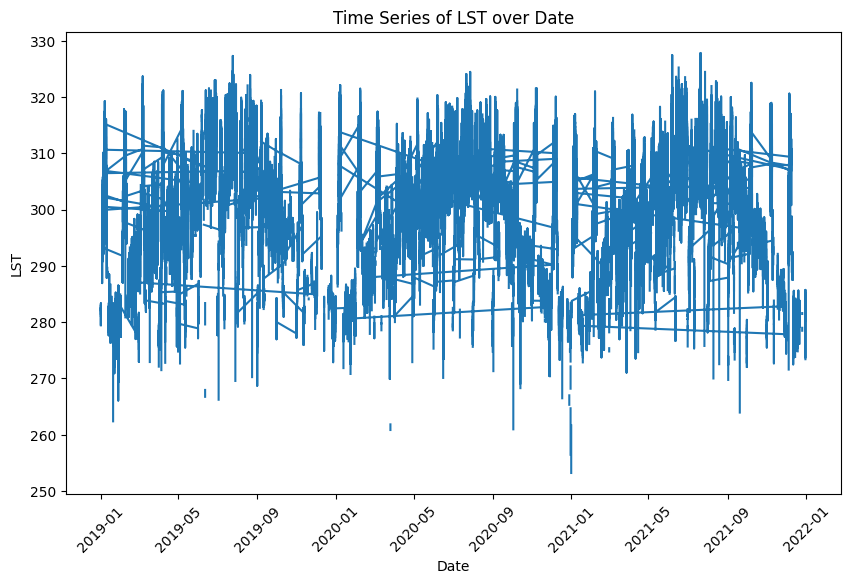

In [105]:
# Plot the time series b/w Date and LST
plt.figure(figsize=(10, 6))
plt.plot(train_df_model_2['Date'], train_df_model_2['LST'])

# Add title and labels
plt.title('Time Series of LST over Date')
plt.xlabel('Date')
plt.ylabel('LST')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#Pattern is cyclical

Text(0, 0.5, 'NO2_strat')

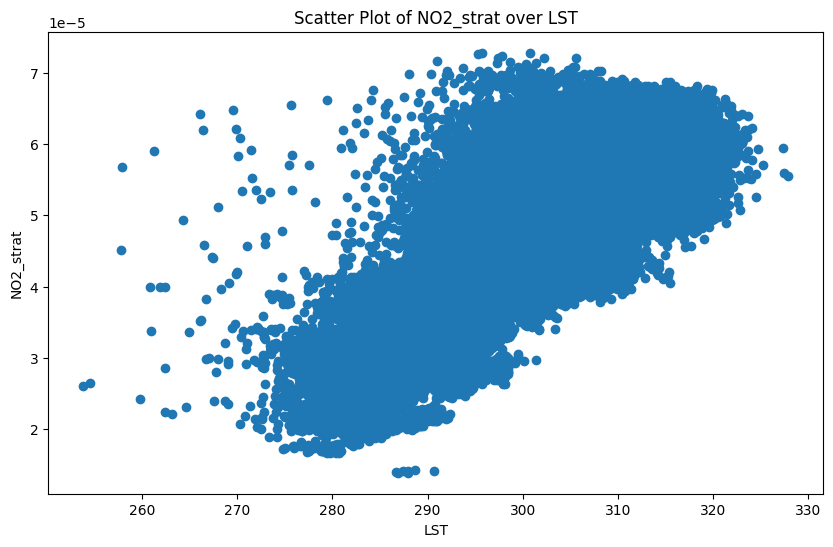

In [106]:
# Plot the scatter plot b/w LST  and NO2_strat
plt.figure(figsize=(10, 6))
plt.scatter(train_df_model_2['LST'], train_df_model_2['NO2_strat'])

# Add title and labels
plt.title('Scatter Plot of NO2_strat over LST')
plt.xlabel('LST')
plt.ylabel('NO2_strat')

#High correlation between both .


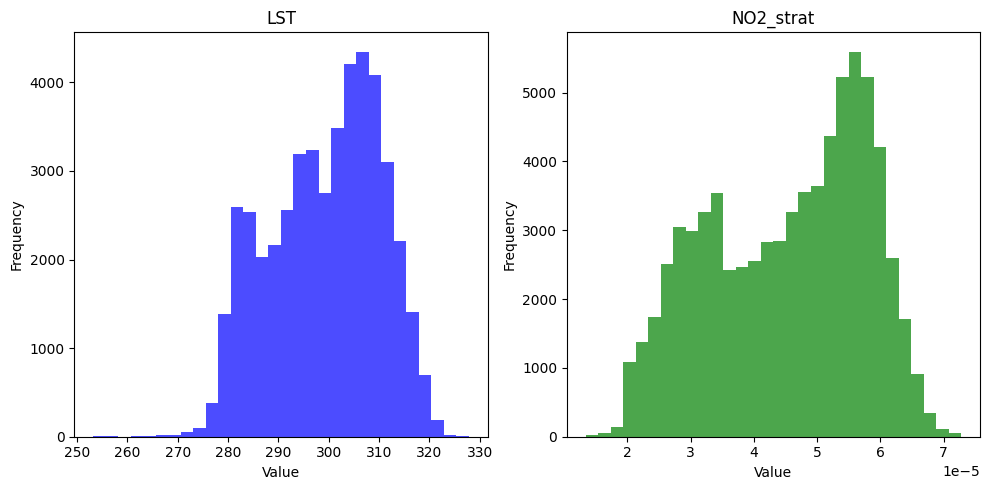

In [107]:
#Checking normality for LST and NO2_strat. We can see 2 peaks and slightly left skewed

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for feature1
axes[0].hist(train_df_model_2['LST'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('LST')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot histogram for feature2
axes[1].hist(train_df_model_2['NO2_strat'], bins=30, color='green', alpha=0.7)
axes[1].set_title('NO2_strat')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [108]:
#checking numeric skewness and kurtosis for LST,NO2_strat and GT_NO2

print('skewness  for LST and NO2_strat:',train_df_model_2['LST'].skew(),train_df_model_2['NO2_strat'].skew(),train_df_model_2['GT_NO2'].skew())
print('Kurtosis for LST and NO2_strat:',train_df_model_2['LST'].kurtosis(),train_df_model_2['NO2_strat'].kurtosis(),train_df_model_2['GT_NO2'].kurtosis())

skewness  for LST and NO2_strat: -0.265339408661245 -0.2923501937449765 1.507939283863649
Kurtosis for LST and NO2_strat: -0.809164556414387 -1.061107954461512 3.319264225804567


In [109]:
train_df_model_2.describe().T
#All 3 have min  of non-negative value so we dont need to treat it for -ve before doing log

,count,mean,min,25%,50%,75%,max,std
Date,86584,2020-07-01 12:00:00,2019-01-01 00:00:00,2019-10-01 18:00:00,2020-07-01 12:00:00,2021-04-01 06:00:00,2021-12-31 00:00:00,NaN
LAT,86584.0,45.421456,44.924694,45.249544,45.478996,45.601232,45.889734,0.225409
LON,86584.0,10.014272,8.736497,9.195325,9.611738,10.683357,12.590682,1.056637
Precipitation,86584.0,2.585528,0.0,0.0,0.0,0.0,135.396805,7.617394
LST,46798.0,299.268841,253.2,290.92,300.76,307.94,327.84,10.927167
AAI,73709.0,-1.274999,-5.196266,-1.749425,-1.349746,-0.878857,2.14302,0.693003
CloudFraction,73709.0,0.200606,0.0,0.0239,0.078478,0.278451,1.0,0.259607
NO2_strat,73709.0,0.000045,0.000013,0.000034,0.000047,0.000056,0.000073,0.000012
NO2_total,73709.0,0.000156,-0.000012,0.0001,0.000122,0.000173,0.002047,0.000103
NO2_trop,73709.0,0.00011,-0.000044,0.000048,0.000074,0.000133,0.002014,0.000108


In [110]:
train_df_model_2_LST_NO2_strat_dff=train_df_model_2.copy()
train_df_model_2_LST_NO2_strat_dff.head(20)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,0.000093,14440.82126,31.000
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,0.000103,14441.79815,42.000
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,0.000062,14437.38294,31.000
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,0.000100,14440.83831,30.000
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,0.000092,14438.79037,58.000
5,ID_4XN0K8,2019-01-01,TV01,45.889734,12.307124,0.000000,278.38,-0.366831,0.324392,0.000023,0.000109,0.000086,14432.05624,26.000
6,ID_O0RJKX,2019-01-01,TV02,45.671721,12.237807,0.000000,NaN,0.188599,0.818422,0.000024,0.000135,0.000111,14436.70176,38.000
7,ID_1APJEY,2019-01-01,VE01,45.629092,12.590682,0.000000,NaN,0.507837,0.926018,0.000024,0.000137,0.000113,14435.01960,34.000
8,ID_4B1H1U,2019-01-01,VE02,45.499618,12.261249,0.000000,NaN,0.087363,0.835097,0.000024,0.000104,0.000080,14438.51425,41.000
9,ID_3JD1GC,2019-01-01,VE03,45.428424,12.312930,0.650355,NaN,0.208678,0.812696,0.000024,0.000117,0.000093,14437.71015,35.000


In [111]:
#As log will have no effect on NO2_Strat due to very small no. i am multiplying it with 1e6 then doing log for all 3 cols
cols_to_transform = ['NO2_strat', 'GT_NO2', 'LST']
train_df_model_2_LST_NO2_strat_dff['NO2_strat_scaled'] = train_df_model_2_LST_NO2_strat_dff['NO2_strat'] * 1e6
for col in cols_to_transform:
    train_df_model_2_LST_NO2_strat_dff[f'{col}_log1p'] = np.log1p(train_df_model_2_LST_NO2_strat_dff[col])
train_df_model_2_LST_NO2_strat_dff.head(20)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,NO2_strat_scaled,NO2_strat_log1p,GT_NO2_log1p,LST_log1p
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,0.000093,14440.82126,31.000,23.8,0.000024,3.465736,NaN
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,0.000103,14441.79815,42.000,23.9,0.000024,3.761200,NaN
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,0.000062,14437.38294,31.000,24.0,0.000024,3.465736,NaN
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,0.000100,14440.83831,30.000,24.1,0.000024,3.433987,NaN
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,0.000092,14438.79037,58.000,24.1,0.000024,4.077537,NaN
5,ID_4XN0K8,2019-01-01,TV01,45.889734,12.307124,0.000000,278.38,-0.366831,0.324392,0.000023,0.000109,0.000086,14432.05624,26.000,23.4,0.000023,3.295837,5.632573
6,ID_O0RJKX,2019-01-01,TV02,45.671721,12.237807,0.000000,NaN,0.188599,0.818422,0.000024,0.000135,0.000111,14436.70176,38.000,23.6,0.000024,3.663562,NaN
7,ID_1APJEY,2019-01-01,VE01,45.629092,12.590682,0.000000,NaN,0.507837,0.926018,0.000024,0.000137,0.000113,14435.01960,34.000,23.6,0.000024,3.555348,NaN
8,ID_4B1H1U,2019-01-01,VE02,45.499618,12.261249,0.000000,NaN,0.087363,0.835097,0.000024,0.000104,0.000080,14438.51425,41.000,23.8,0.000024,3.737670,NaN
9,ID_3JD1GC,2019-01-01,VE03,45.428424,12.312930,0.650355,NaN,0.208678,0.812696,0.000024,0.000117,0.000093,14437.71015,35.000,23.8,0.000024,3.583519,NaN


Text(0, 0.5, 'NO2_strat')

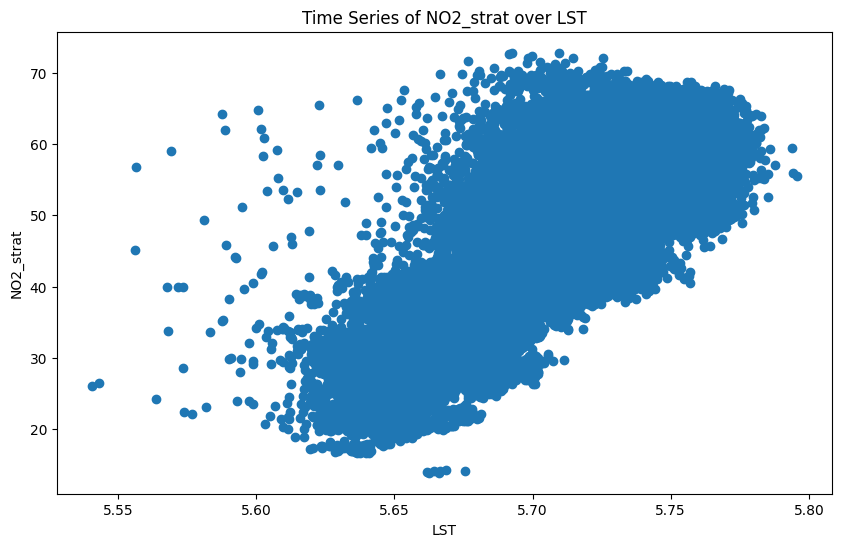

In [112]:
#LST vs NO2_strat aftfer log is somewhat better but still the variability is increasing.

plt.figure(figsize=(10, 6))
plt.scatter(train_df_model_2_LST_NO2_strat_dff['LST_log1p'], train_df_model_2_LST_NO2_strat_dff['NO2_strat_scaled'])

# Add title and labels
plt.title('Time Series of NO2_strat over LST')
plt.xlabel('LST')
plt.ylabel('NO2_strat')

In [113]:
#checking skewness and kurtosis for both after log

print('skewness  for LST and NO2_strat:',train_df_model_2_LST_NO2_strat_dff['LST_log1p'].skew(),train_df_model_2_LST_NO2_strat_dff['NO2_strat_log1p'].skew(),train_df_model_2_LST_NO2_strat_dff['GT_NO2_log1p'].skew())
print('Kurtosis for LST and NO2_strat:',train_df_model_2_LST_NO2_strat_dff['LST_log1p'].kurtosis(),train_df_model_2_LST_NO2_strat_dff['NO2_strat_log1p'].kurtosis(),train_df_model_2_LST_NO2_strat_dff['GT_NO2_log1p'].kurtosis())

skewness  for LST and NO2_strat: -0.3274498480002951 -0.29236602430581615 -0.1936745511568207
Kurtosis for LST and NO2_strat: -0.7523240286304858 -1.061099000821226 -0.14417178491165838


In [114]:
print('Before')
train_df_model_2_corr_matrix_df_sort[train_df_model_2_corr_matrix_df_sort['Variable2']=='GT_NO2']

Before


,Variable1,Variable2,Correlation
98,NO2_trop,GT_NO2,0.726991
87,NO2_total,GT_NO2,0.596019
10,LAT,GT_NO2,0.175449
54,AAI,GT_NO2,0.168820
109,TropopausePressure,GT_NO2,0.048618
65,CloudFraction,GT_NO2,0.011319
32,Precipitation,GT_NO2,-0.032344
21,LON,GT_NO2,-0.102680
43,LST,GT_NO2,-0.519646
76,NO2_strat,GT_NO2,-0.558997


In [115]:
train_df_model_2_LST_NO2_strat_dff_corr=train_df_model_2_LST_NO2_strat_dff[['LST_log1p','NO2_strat_log1p','GT_NO2_log1p']]
train_df_model_2_LST_NO2_strat_dff_corr.head(5)

,LST_log1p,NO2_strat_log1p,GT_NO2_log1p
0,NaN,0.000024,3.465736
1,NaN,0.000024,3.761200
2,NaN,0.000024,3.465736
3,NaN,0.000024,3.433987
4,NaN,0.000024,4.077537


In [116]:
print('After log')
train_df_model_2_LST_NO2_strat_dff_corr=train_df_model_2_LST_NO2_strat_dff_corr.corr()
train_df_model_2_LST_NO2_strat_dff_corr

After log


,LST_log1p,NO2_strat_log1p,GT_NO2_log1p
LST_log1p,1.000000,0.825297,-0.513946
NO2_strat_log1p,0.825297,1.000000,-0.564237
GT_NO2_log1p,-0.513946,-0.564237,1.000000


In [117]:
#As NO2_strat_log1p and LST_log1p have high correlation we will fill the missing values in LST_log1p using linear regression.Null values in LST: 46 % and NO2_strat: 15%
filtered_df = train_df_model_2_LST_NO2_strat_dff[train_df_model_2_LST_NO2_strat_dff['NO2_strat_log1p'].notna() & train_df_model_2_LST_NO2_strat_dff['LST_log1p'].notna()]
X = filtered_df[['NO2_strat_log1p']]
y = filtered_df['LST_log1p']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [118]:
train_df_model_2_LST_NO2_strat_dff['dependent_predicted'] = train_df_model_2_LST_NO2_strat_dff.apply(
    lambda row: model.predict([[row['NO2_strat_log1p']]])[0] if pd.isna(row['LST_log1p']) and pd.notna(row['NO2_strat_log1p']) else row['LST_log1p'],
    axis=1
)


In [119]:
# Fill the original 'dependent' column with the predicted values i.e 30% of missing LST
train_df_model_2_LST_NO2_strat_dff['LST_log1p'] = train_df_model_2_LST_NO2_strat_dff.apply(
    lambda row: row['dependent_predicted'] if pd.isna(row['LST_log1p']) else row['LST_log1p'],
    axis=1
)

# Drop the temporary 'dependent_predicted' column
train_df_model_2_LST_NO2_strat_dff.drop(columns=['dependent_predicted'], inplace=True)

In [120]:
print('Before')
train_df_model_2_corr_matrix_df_sort[train_df_model_2_corr_matrix_df_sort['Variable2']=='GT_NO2']

Before


,Variable1,Variable2,Correlation
98,NO2_trop,GT_NO2,0.726991
87,NO2_total,GT_NO2,0.596019
10,LAT,GT_NO2,0.175449
54,AAI,GT_NO2,0.168820
109,TropopausePressure,GT_NO2,0.048618
65,CloudFraction,GT_NO2,0.011319
32,Precipitation,GT_NO2,-0.032344
21,LON,GT_NO2,-0.102680
43,LST,GT_NO2,-0.519646
76,NO2_strat,GT_NO2,-0.558997


In [121]:
#new correlations after imputation
train_df_model_2_LST_NO2_strat_dff_corr=train_df_model_2_LST_NO2_strat_dff[['LST_log1p','NO2_strat_log1p','GT_NO2_log1p']].corr()
train_df_model_2_LST_NO2_strat_dff_corr
'''
#We have increased the correlation b/w LST and GT_NO2_log1p. 
#We did the following transformations till  now
#1) Filled 255 null in NO2_trop doing NO2_TOTAL minus NO2_STRAT
#2) Did log transform in LST, NO2_STRAT, GT_NO2. As NO2_STRAT had very small values we did ['NO2_strat'] * 1e6 then did log for this col. 
 Null values in LST: 46 % and NO2_strat: 15%. So we will but around 30% of missing values in LST using linear regssion on these log transformed cols.
'''

"\n#We have increased the correlation b/w LST and GT_NO2_log1p. \n#We did the following transformations till  now\n#1) Filled 255 null in NO2_trop doing NO2_TOTAL minus NO2_STRAT\n#2) Did log transform in LST, NO2_STRAT, GT_NO2. As NO2_STRAT had very small values we did ['NO2_strat'] * 1e6 then did log for this col. \n Null values in LST: 46 % and NO2_strat: 15%. So we will but around 30% of missing values in LST using linear regssion on these log transformed cols.\n"

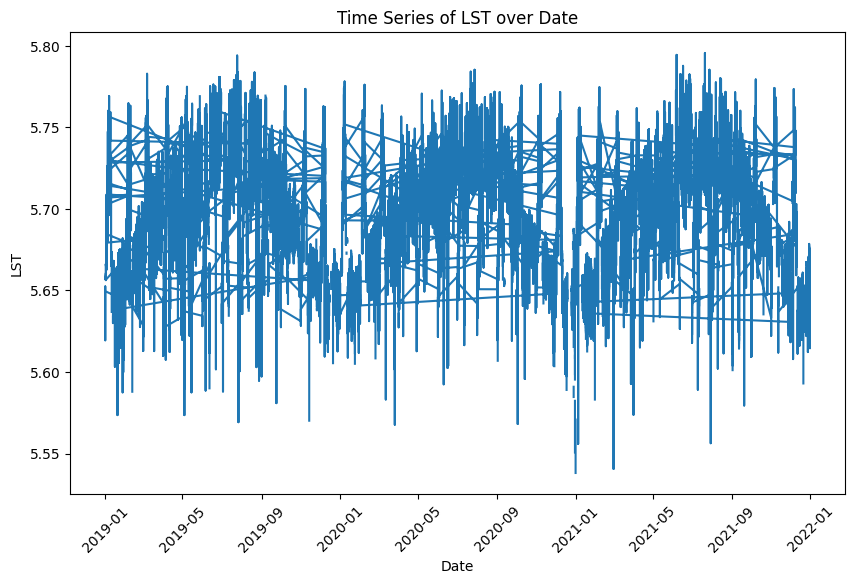

In [122]:
# Plot the time series b/w Date and LST
plt.figure(figsize=(10, 6))
plt.plot(train_df_model_2_LST_NO2_strat_dff['Date'], train_df_model_2_LST_NO2_strat_dff['LST_log1p'])

# Add title and labels
plt.title('Time Series of LST over Date')
plt.xlabel('Date')
plt.ylabel('LST')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [123]:
#Let's see if we have any  null for any of the NO2 col while we have not null in other NO2 col.
columns_to_check_NO2_null=['NO2_trop','NO2_total','NO2_strat','AAI','TropopausePressure']
columns_to_check_NO2_null_df=train_df_model_2_LST_NO2_strat_dff.dropna(subset=columns_to_check_NO2_null)
print(columns_to_check_NO2_null_df.shape,train_df_model_2_LST_NO2_strat_dff.shape,train_df_model_2_LST_NO2_strat_dff.shape[0]-columns_to_check_NO2_null_df.shape[0])

#If a NO2 row is null other NO2 rows are also NULL.We went back and added AAI and TropopausePressure too in the subset of column.

(73709, 18) (86584, 18) 12875


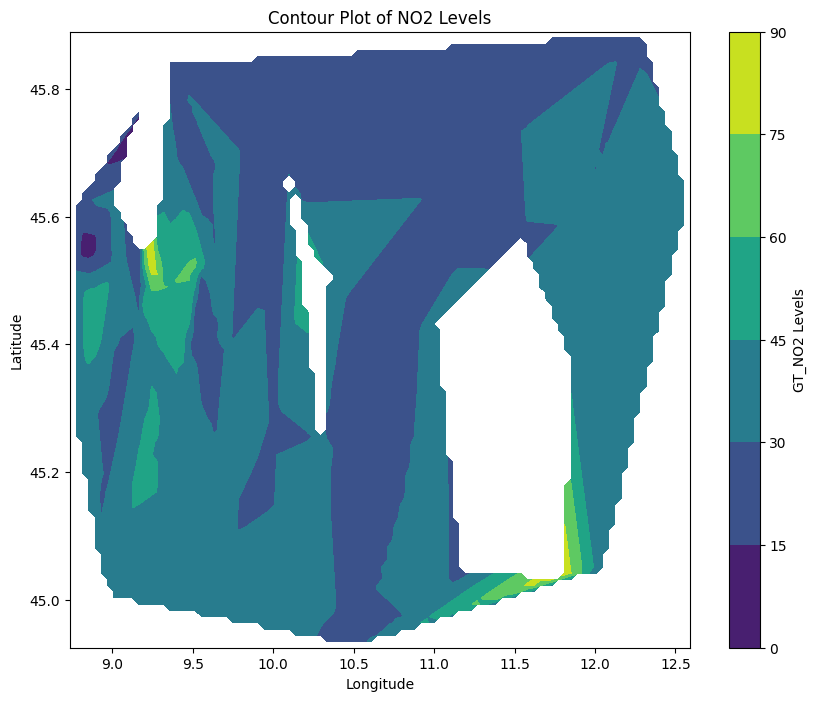

In [124]:
#Creating countour plot for LAT, LON with NO2
lon = np.linspace(train_df_model_2_LST_NO2_strat_dff['LON'].min(), train_df_model_2_LST_NO2_strat_dff['LON'].max(), 100)
lat = np.linspace(train_df_model_2_LST_NO2_strat_dff['LAT'].min(), train_df_model_2_LST_NO2_strat_dff['LAT'].max(), 100)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Interpolate NO2 values to the grid
no2_grid = griddata((train_df_model_2_LST_NO2_strat_dff['LON'], train_df_model_2_LST_NO2_strat_dff['LAT']), train_df_model_2_LST_NO2_strat_dff['GT_NO2'], (lon_grid, lat_grid), method='linear')

# Plotting the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(lon_grid, lat_grid, no2_grid, cmap='viridis')
plt.colorbar(contour, label='GT_NO2 Levels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contour Plot of NO2 Levels')
plt.show()


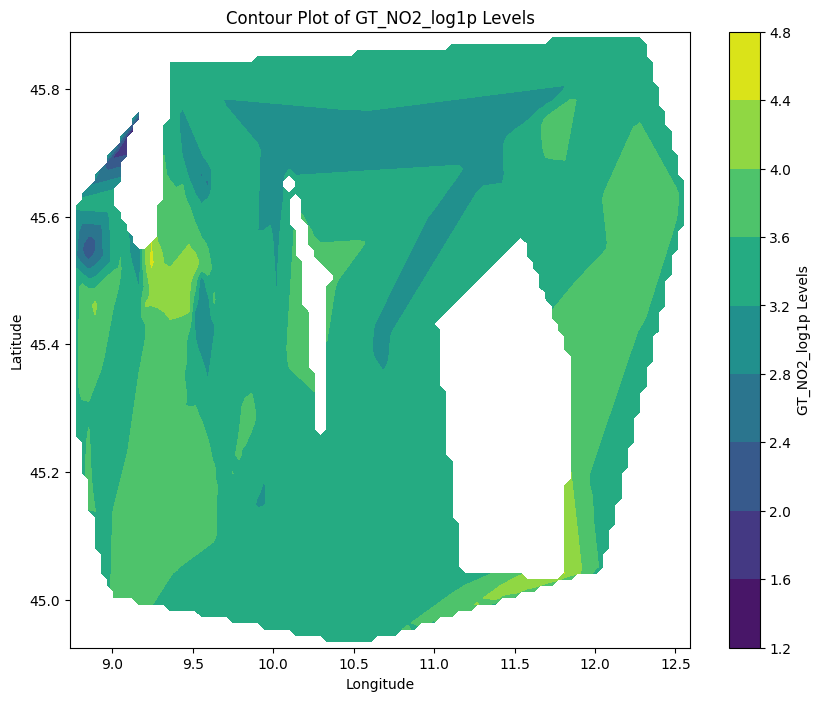

In [125]:
#Creating countour plot for LAT, LON with GT_NO2_log1p
lon = np.linspace(train_df_model_2_LST_NO2_strat_dff['LON'].min(), train_df_model_2_LST_NO2_strat_dff['LON'].max(), 100)
lat = np.linspace(train_df_model_2_LST_NO2_strat_dff['LAT'].min(), train_df_model_2_LST_NO2_strat_dff['LAT'].max(), 100)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Interpolate NO2 values to the grid
no2_grid = griddata((train_df_model_2_LST_NO2_strat_dff['LON'], train_df_model_2_LST_NO2_strat_dff['LAT']), train_df_model_2_LST_NO2_strat_dff['GT_NO2_log1p'], (lon_grid, lat_grid), method='linear')

# Plotting the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(lon_grid, lat_grid, no2_grid, cmap='viridis')
plt.colorbar(contour, label='GT_NO2_log1p Levels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contour Plot of GT_NO2_log1p Levels')
plt.show()


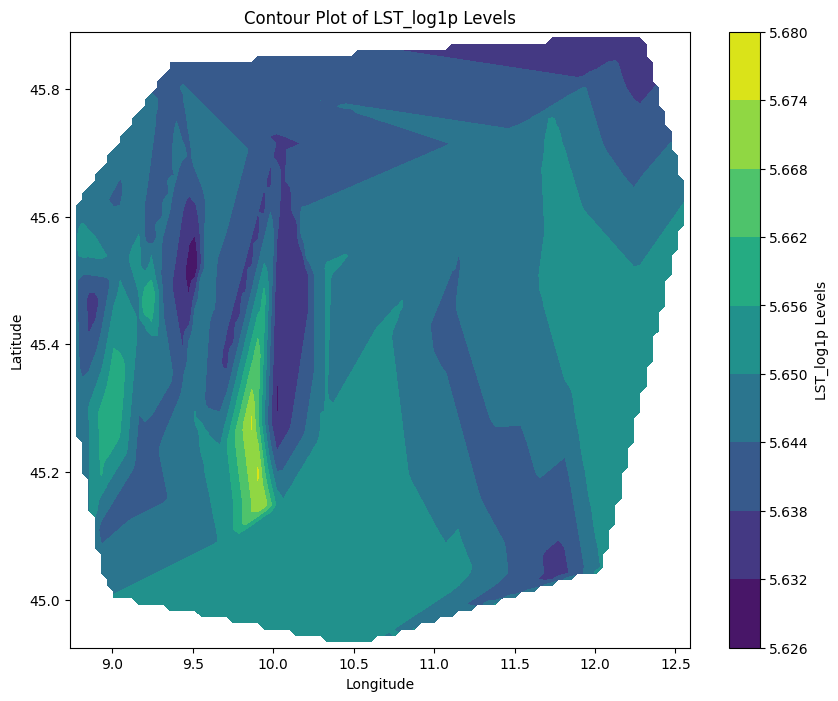

In [126]:
#Creating countour plot for LAT, LON with LST_log1p
lon = np.linspace(train_df_model_2_LST_NO2_strat_dff['LON'].min(), train_df_model_2_LST_NO2_strat_dff['LON'].max(), 100)
lat = np.linspace(train_df_model_2_LST_NO2_strat_dff['LAT'].min(), train_df_model_2_LST_NO2_strat_dff['LAT'].max(), 100)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Interpolate NO2 values to the grid
no2_grid = griddata((train_df_model_2_LST_NO2_strat_dff['LON'], train_df_model_2_LST_NO2_strat_dff['LAT']), train_df_model_2_LST_NO2_strat_dff['LST_log1p'], (lon_grid, lat_grid), method='linear')

# Plotting the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(lon_grid, lat_grid, no2_grid, cmap='viridis')
plt.colorbar(contour, label='LST_log1p Levels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contour Plot of LST_log1p Levels')
plt.show()

#Plot against GT_NO2_log1p had some blank values  while in LST_log1p had darker blue .It maybe a waterbody which means low temperature and low NO2
#In norhteast we can see low temperature and low NO2
#We have the highest temeperation at around  LOG: 10 and LAT:45.1 to 45.4 . We can see high NO2 in this area too. Most probably is urbban area.

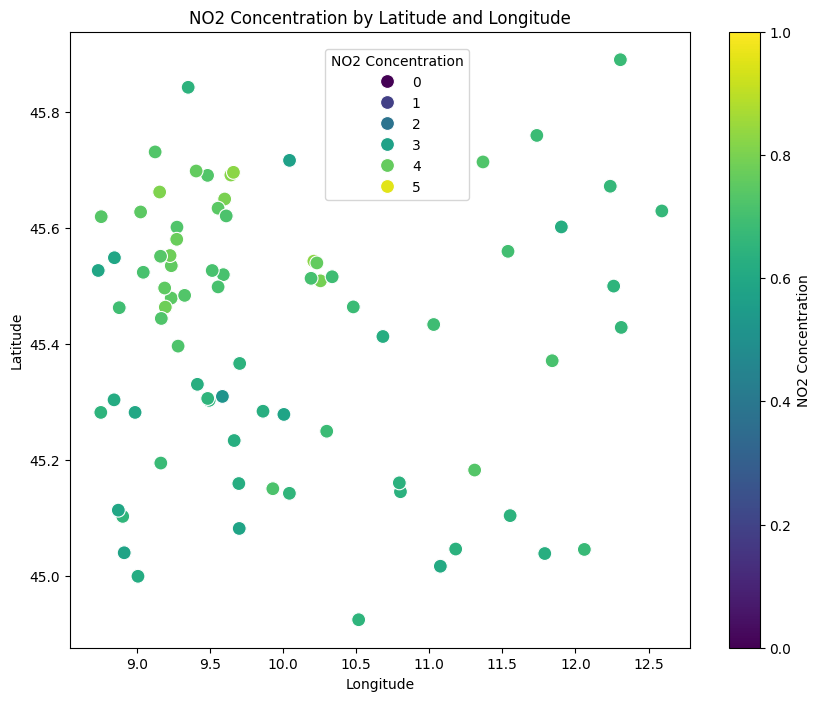

In [127]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='LON', y='LAT', hue='GT_NO2_log1p', palette='viridis', data=train_df_model_2_LST_NO2_strat_dff, s=100)
plt.title('NO2 Concentration by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Move the legend to the side
plt.legend(title='NO2 Concentration', loc='center left', bbox_to_anchor=(0.4, 0.85))

# Add colorbar
cbar = plt.colorbar(scatter.get_children()[0], ax=scatter.axes)
cbar.set_label('NO2 Concentration')

plt.show()


In [128]:
# #Before doing k -means mini batch clustering lets do elbow method to find best cluster size


# # Function to calculate WCSS
# df_lat_log = train_df_model_2_LST_NO2_strat_dff[['LAT','LON']].copy()
# def calculate_wcss(data, max_clusters):
#     wcss = []
#     for n in range(1, max_clusters + 1):
#         kmeans = MiniBatchKMeans(n_clusters=n, batch_size=4000, random_state=0, init='k-means++')
#         kmeans.fit(data)
#         wcss.append(kmeans.inertia_)
#     return wcss

# # Define the range of clusters to test
# max_clusters = 15

# # Calculate WCSS for different numbers of clusters
# wcss = calculate_wcss(df_lat_log, max_clusters)

# # Plot the Elbow Method graph
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
# plt.title('Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

In [129]:

# Vectorized Haversine distance calculation
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Function to process batches
def process_batch(batch):
    n = len(batch)
    X = np.zeros((n, 2))
    lat1 = batch['LAT'].values
    lon1 = batch['LON'].values
    
    for i in range(n):
        dists = haversine_vectorized(lat1[i], lon1[i], lat1, lon1)
        X[i, 0] += np.sum(dists)
        X[i, 1] += np.sum(dists)
    
    X /= np.max(X)
    return X

def process_batches(df, batch_size=3000, n_jobs=-1):
    num_batches = int(np.ceil(len(df) / batch_size))
    batches = [df.iloc[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]
    
    all_data = Parallel(n_jobs=n_jobs)(delayed(process_batch)(batch) for batch in batches)
    
    return np.vstack(all_data)

# # # # Silhouette analysis
# train_df_model_2_LAT_LON_dff = train_df_model_2_LST_NO2_strat_dff[['LAT', 'LON']].copy()

# for i in range(2,10):
#     # Process in batches
#     X = process_batches(train_df_model_2_LAT_LON_dff)

#     # Apply k-means clustering
#     kmeans = KMeans(n_clusters=i)  # Adjust the number of clusters as needed
#     labels = kmeans.fit_predict(X)

#     # Silhouette analysis
#     silhouette_avg = silhouette_score(X, labels)
#     print(f"The average silhouette_score for {i} clusters is: {silhouette_avg}")

In [130]:
# Process in batches
train_df_model_2_LAT_LON_dff=train_df_model_2_LST_NO2_strat_dff[['LAT', 'LON']].copy()
X = process_batches(train_df_model_2_LAT_LON_dff)

# Apply k-means clustering
kmeans = KMeans(n_clusters=7)  
labels = kmeans.fit_predict(X)
cluster_centers=kmeans.cluster_centers_
train_df_model_2_LST_NO2_strat_dff['cluster_labels']=labels

    # Silhouette analysis
silhouette_avg = silhouette_score(X, labels)
print(silhouette_avg)


0.6588820754525687


In [131]:
label_map = {0: 'A', 1: 'B', 2: 'C',3:'D',4:'E',5:'F',6:'G'}
train_df_model_2_LST_NO2_strat_dff['cluster_labels'] = train_df_model_2_LST_NO2_strat_dff['cluster_labels'].map(label_map)
train_df_model_2_LST_NO2_strat_dff.groupby('cluster_labels').size()

cluster_labels
A    16723
B     4384
C    14248
D     6576
E     6576
F    10927
G    27150
dtype: int64

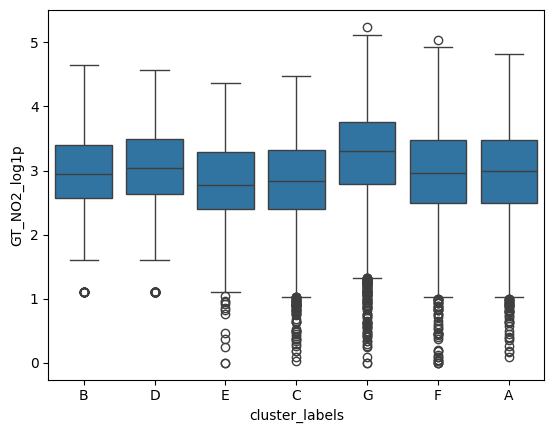

In [132]:
# Box plot
sns.boxplot(x='cluster_labels', y='GT_NO2_log1p', data=train_df_model_2_LST_NO2_strat_dff)
plt.show()

In [133]:
#Analysis cluster_labels against Ground NO2

display(train_df_model_2_LST_NO2_strat_dff.groupby('cluster_labels')['GT_NO2_log1p'].describe())

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
A,16345.0,2.976278,0.658240,0.095310,2.495269,2.994481,3.482777,4.821692
B,4283.0,2.965566,0.557641,1.098612,2.564949,2.944439,3.401197,4.653960
C,13769.0,2.833625,0.626576,0.024693,2.402430,2.828792,3.323236,4.482720
D,6484.0,3.055978,0.560304,1.098612,2.639057,3.044522,3.496508,4.574711
E,6467.0,2.818718,0.611656,0.000000,2.397895,2.772589,3.295837,4.369448
F,10408.0,2.971950,0.687090,0.000000,2.497329,2.960105,3.483737,5.043102
G,24295.0,3.255331,0.682632,0.000000,2.788093,3.307802,3.762943,5.242981


In [134]:
#Analysis cluster_labels against CloudFraction

display(train_df_model_2_LST_NO2_strat_dff.groupby('cluster_labels')['CloudFraction'].describe())
median_values_CF = train_df_model_2_LST_NO2_strat_dff.groupby('cluster_labels')['CloudFraction'].median()
print(median_values_CF)


,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
A,13807.0,0.182066,0.244865,0.0,0.020600,0.069382,0.244318,1.0
B,3891.0,0.226705,0.270211,0.0,0.030056,0.102716,0.336456,1.0
C,12272.0,0.200301,0.268985,0.0,0.017034,0.067073,0.280582,1.0
D,5953.0,0.215624,0.272953,0.0,0.018919,0.080665,0.326060,1.0
E,5770.0,0.222848,0.276586,0.0,0.024480,0.091831,0.329203,1.0
F,9250.0,0.193428,0.260497,0.0,0.018906,0.071288,0.259088,1.0
G,22766.0,0.200906,0.251810,0.0,0.031758,0.086833,0.270786,1.0


cluster_labels
A    0.069382
B    0.102716
C    0.067073
D    0.080665
E    0.091831
F    0.071288
G    0.086833
Name: CloudFraction, dtype: float64


In [135]:
train_df_model_2_LST_NO2_strat_dff=pd.get_dummies(train_df_model_2_LST_NO2_strat_dff,columns=['cluster_labels'],drop_first=False)

In [136]:
train_df_model_2_LST_NO2_strat_dff.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,NO2_strat_scaled,NO2_strat_log1p,GT_NO2_log1p,LST_log1p,cluster_labels_A,cluster_labels_B,cluster_labels_C,cluster_labels_D,cluster_labels_E,cluster_labels_F,cluster_labels_G
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,0.000093,14440.82126,31.0,23.8,0.000024,3.465736,5.650772,False,True,False,False,False,False,False
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,0.000103,14441.79815,42.0,23.9,0.000024,3.761200,5.651014,False,True,False,False,False,False,False
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,0.000062,14437.38294,31.0,24.0,0.000024,3.465736,5.651255,False,False,False,True,False,False,False
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,0.000100,14440.83831,30.0,24.1,0.000024,3.433987,5.651497,False,False,False,False,True,False,False
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,0.000092,14438.79037,58.0,24.1,0.000024,4.077537,5.651497,False,True,False,False,False,False,False


In [137]:
print(perform_data_analysis(train_df_model_2_LST_NO2_strat_dff,test_df_model_2))

Null check in train_df:


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,datetime64[ns]
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,68723,79.371477,float64
LST,39786,45.950753,0,0.000000,float64
AAI,12875,14.869953,0,0.000000,float64
CloudFraction,12875,14.869953,7756,8.957775,float64
NO2_strat,12875,14.869953,0,0.000000,float64


Null check in test_df:


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,object
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,5228,79.501217,float64
LST,2981,45.331509,0,0.000000,float64
AAI,868,13.199513,0,0.000000,float64
CloudFraction,868,13.199513,874,13.290754,float64
NO2_strat,868,13.199513,0,0.000000,float64


Null check in combined_df:
Combined_df shape:  (93160, 24)
Is rows in train_df + test_df = combined_df? True


,Null count,Null_count_percent,Zero count,Zero_count_percent,Datatype
ID_Zindi,0,0.000000,0,0.000000,object
Date,0,0.000000,0,0.000000,object
ID,0,0.000000,0,0.000000,object
LAT,0,0.000000,0,0.000000,float64
LON,0,0.000000,0,0.000000,float64
Precipitation,0,0.000000,73951,79.380635,float64
LST,42767,45.907042,0,0.000000,float64
AAI,13743,14.752040,0,0.000000,float64
CloudFraction,13743,14.752040,8630,9.263632,float64
NO2_strat,13743,14.752040,0,0.000000,float64


Check describe for train_df


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID_Zindi,86584,86582,ID_ZHFIGQ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,86584,NaN,NaN,NaN,2020-07-01 12:00:00,2019-01-01 00:00:00,2019-10-01 18:00:00,2020-07-01 12:00:00,2021-04-01 06:00:00,2021-12-31 00:00:00,NaN
ID,86584,79,PD01,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,86584.0,NaN,NaN,NaN,45.421456,44.924694,45.249544,45.478996,45.601232,45.889734,0.225409
LON,86584.0,NaN,NaN,NaN,10.014272,8.736497,9.195325,9.611738,10.683357,12.590682,1.056637
Precipitation,86584.0,NaN,NaN,NaN,2.585528,0.0,0.0,0.0,0.0,135.396805,7.617394
LST,46798.0,NaN,NaN,NaN,299.268841,253.2,290.92,300.76,307.94,327.84,10.927167
AAI,73709.0,NaN,NaN,NaN,-1.274999,-5.196266,-1.749425,-1.349746,-0.878857,2.14302,0.693003
CloudFraction,73709.0,NaN,NaN,NaN,0.200606,0.0,0.0239,0.078478,0.278451,1.0,0.259607
NO2_strat,73709.0,NaN,NaN,NaN,0.000045,0.000013,0.000034,0.000047,0.000056,0.000073,0.000012


Check describe for test_df


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_Zindi,6576,6576,ID_2MYNQS,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,6576,1096,1/1/19,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,6576,6,PD03,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,6576.0,NaN,NaN,NaN,45.363205,0.260667,45.131947,45.151743,45.237853,45.582894,45.836941
LON,6576.0,NaN,NaN,NaN,10.489789,1.306469,8.842165,9.146666,10.398575,11.642394,12.510362
Precipitation,6576.0,NaN,NaN,NaN,2.544018,7.475326,0.0,0.0,0.0,0.0,103.227943
LST,3595.0,NaN,NaN,NaN,299.394019,11.034047,254.72,291.04,300.9,308.12,324.14
AAI,5708.0,NaN,NaN,NaN,-1.27339,0.691949,-3.716866,-1.753032,-1.363993,-0.876478,2.474583
CloudFraction,5708.0,NaN,NaN,NaN,0.203512,0.269866,0.0,0.01336,0.070884,0.296377,1.0
NO2_strat,5708.0,NaN,NaN,NaN,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000072


Check describe for combined_df


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID_Zindi,93160,93158,ID_ZHFIGQ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,93160,2192,2019-01-01 00:00:00,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,93160,85,PD01,1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,93160.0,NaN,NaN,NaN,45.417344,0.228563,44.924694,45.233494,45.463753,45.582894,45.889734
LON,93160.0,NaN,NaN,NaN,10.047838,1.083039,8.736497,9.195325,9.643651,10.781408,12.590682
Precipitation,93160.0,NaN,NaN,NaN,2.582597,7.607421,0.0,0.0,0.0,0.0,135.396805
LST,50393.0,NaN,NaN,NaN,299.277771,10.934763,253.2,290.94,300.78,307.94,327.84
AAI,79417.0,NaN,NaN,NaN,-1.274884,0.692923,-5.196266,-1.749649,-1.350884,-0.878793,2.474583
CloudFraction,79417.0,NaN,NaN,NaN,0.200815,0.260357,0.0,0.023168,0.077997,0.279655,1.0
NO2_strat,79417.0,NaN,NaN,NaN,0.000045,0.000012,0.000013,0.000034,0.000047,0.000056,0.000073


Check for dataype mismatch between Train and Test.If True then no mismatch: (False, [('Date', {'train': dtype('<M8[ns]'), 'test': dtype('O')})])
Check for duplicates in train_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,NO2_strat_scaled,NO2_strat_log1p,GT_NO2_log1p,LST_log1p,cluster_labels_A,cluster_labels_B,cluster_labels_C,cluster_labels_D,cluster_labels_E,cluster_labels_F,cluster_labels_G


Check for duplicates in test_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure


Check for duplicates in combined_df


,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,NO2_strat_scaled,NO2_strat_log1p,GT_NO2_log1p,LST_log1p,cluster_labels_A,cluster_labels_B,cluster_labels_C,cluster_labels_D,cluster_labels_E,cluster_labels_F,cluster_labels_G


None


In [138]:
#We still have nulls in multiple columns. But first let's create another model with whatever changes we have done.
train_df_model_2_LST_NO2_strat_dff.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,NO2_strat_scaled,NO2_strat_log1p,GT_NO2_log1p,LST_log1p,cluster_labels_A,cluster_labels_B,cluster_labels_C,cluster_labels_D,cluster_labels_E,cluster_labels_F,cluster_labels_G
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,0.000093,14440.82126,31.0,23.8,0.000024,3.465736,5.650772,False,True,False,False,False,False,False
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,0.000103,14441.79815,42.0,23.9,0.000024,3.761200,5.651014,False,True,False,False,False,False,False
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,0.000062,14437.38294,31.0,24.0,0.000024,3.465736,5.651255,False,False,False,True,False,False,False
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,0.000100,14440.83831,30.0,24.1,0.000024,3.433987,5.651497,False,False,False,False,True,False,False
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,0.000092,14438.79037,58.0,24.1,0.000024,4.077537,5.651497,False,True,False,False,False,False,False


In [139]:
Columns_to_work_with=['cluster_labels_A','cluster_labels_B','cluster_labels_C','cluster_labels_D','cluster_labels_E','cluster_labels_F','cluster_labels_G',
                      'Precipitation','NO2_strat_log1p','NO2_total','NO2_trop',
                      'GT_NO2_log1p','LST_log1p','AAI',
                      'CloudFraction','TropopausePressure']

train_df_model_2_LST_NO2_strat_dff_mod_2=train_df_model_2_LST_NO2_strat_dff[Columns_to_work_with]
X=train_df_model_2_LST_NO2_strat_dff_mod_2.drop(['GT_NO2_log1p'],axis=1)
y=train_df_model_2_LST_NO2_strat_dff_mod_2['GT_NO2_log1p']

y_converted_back=np.expm1(y)
y_org=y
X=X.fillna(0)
y=y.fillna(0)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=52)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)
y_test2_converted_back=np.expm1(y_test2)

(69267, 15) (17317, 15) (69267,) (17317,)


In [140]:
# Initialize the linear regression model
model2 = LinearRegression()

# Train the model
model2.fit(X_train2, y_train2)

# Make predictions on the test set
y_pred2 = model2.predict(X_test2)

y_pred2_converted_back=np.expm1(y_pred2)
# Evaluate the model
mse = mean_squared_error(y_test2_converted_back, y_pred2_converted_back)
rmse = np.sqrt(mse)
r2 = r2_score(y_test2_converted_back, y_pred2_converted_back)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 296.5683202811644
Root Mean Squared Error: 17.221159086460016
R-squared: 0.01947817257577511


In [141]:
y_pred2_converted_back

array([ 8.20709524, 29.07396861, 26.03039606, ..., 19.91123086,
       18.46833391, 18.11377133])

In [144]:
X_train2.head(5)

,cluster_labels_A,cluster_labels_B,cluster_labels_C,cluster_labels_D,cluster_labels_E,cluster_labels_F,cluster_labels_G,Precipitation,NO2_strat_log1p,NO2_total,NO2_trop,LST_log1p,AAI,CloudFraction,TropopausePressure
74627,True,False,False,False,False,False,False,0.000000,0.000066,0.000120,0.000050,5.752915,-0.321109,0.139100,19299.19866
40760,False,False,False,False,False,False,True,0.000000,0.000052,0.000093,0.000041,5.739986,-2.513709,0.077418,19314.82411
42254,False,False,True,False,False,False,False,0.000000,0.000053,0.000087,0.000033,5.716962,-1.537062,0.055091,19297.22747
81695,False,False,False,True,False,False,False,0.000000,0.000034,0.000256,0.000222,5.662683,0.275417,0.190287,14432.57267
9765,False,False,False,False,False,False,True,32.509567,0.000060,0.000096,0.000036,5.738910,-1.846722,0.327342,16687.58056


In [143]:
# Mean Squared Error: 182.40370236092463
# Root Mean Squared Error: 13.505691480295432
# R-squared: 0.4026951110506707

#Alas, the model became worst

35


ModuleNotFoundError: No module named 'nicegui'

In [149]:
pip install nicegui

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of python-engineio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of python-engineio to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
ERROR: Cannot install python-socketio because these package versions have conflicting dependencies.

The conflict is caused by:
    python-engineio 4.9.1 depends on simple-websocket>=0.10.0
    python-engineio

ModuleNotFoundError: No module named 'nicegui'

ModuleNotFoundError: No module named 'nicegui'

disabling auto-reloading because is is only supported when running from a file


RuntimeError: asyncio.run() cannot be called from a running event loop

In [4]:
from nicegui import ui

ui.label('Hello NiceGUI!')

ui.run()

disabling auto-reloading because is is only supported when running from a file


RuntimeError: asyncio.run() cannot be called from a running event loop